In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        print(Data)
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [4]:
x, validData, testData, y, validTarget, testTarget = loadData()

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

In [4]:
y.shape

(3500, 1)

def MSE(W, b, x, y, reg):
    sum = 0
    for i in range(len(x)):
        sum += (np.linalg.norm(np.dot(W.flatten(),x[i].flatten()) + b[i] - y[i])**2)*(1/(2*len(x))) + (reg/2)*((np.linalg.norm(W))**2)
    return sum

In [5]:
def MSE(W, b, x, y, reg):
    mse = 0
# =============================================================================
#   Checking the dimensions of the matrices
#     print(np.shape(x))
#     print(np.shape(W))
#   Note: it's faster to multiple than divide by 5%
# =============================================================================
    mse = np.sum(((W.transpose() @ x.transpose())+b-y.transpose())**2)*(1/(2*len(y)))
    mse+= (reg/2)*(np.linalg.norm(W)**2)
    return mse

In [6]:
print(MSE(np.ones(28*28), np.zeros(3500), x, y, 0.1))

AttributeError: module 'numpy' has no attribute 'Transpose'

def gradMSE(W, b, x, y, reg):
    
    GradWRTW = np.zeros(shape = (28,28))
    GradWRTB = 0
    for i in range(len(x)):
        GradWRTW += ((np.linalg.norm(np.dot(W.flatten(),(x[i].flatten()).T) + b[i] - y[i]))*x[i]*(1/(len(x))) + reg*((np.linalg.norm(W)))).reshape(28, 28)
        GradWRTB += ((np.linalg.norm(np.dot(W.flatten(),(x[i].flatten()).T) + b[i] - y[i])))*(1/(len(x)))
    
    return GradWRTW, GradWRTB
    
    

In [6]:
def gradMSE(W, b, x, y, reg):
 
 #=============================================================================
#     gradB is 1x3500 array
#     x is 3500x784 array
# =============================================================================
    
    gradB= (1/len(y))*((W.transpose() @ x.transpose()) + b - y.transpose())
#    print(np.shape(gradB)) # results above
    gradW= (gradB @ x).transpose() + reg*W
    gradB = np.sum(gradB)
    
    return gradW, gradB

In [7]:
def sigmoidZ(x,W,b):
    #print(np.shape(W),np.shape(x))
    return(1/(1+np.exp(-(W.transpose() @ x.transpose() + b))))

In [8]:
def safelog(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

In [9]:
def crossEntropyLoss(W, b, x, y, reg):
    loss = np.sum((1/len(y)) * (-y * safelog(sigmoidZ(x,W,b)) - (1-y) * safelog(1-sigmoidZ(x,W,b))))
    loss+= (reg/2)*np.linalg.norm(W)**2
    #print("Loss is: ",loss)
    return loss

In [10]:
def gradCE(W, b, x, y, reg):
    sigmoid = sigmoidZ(x,W,b).clip(min=np.finfo(np.float).eps,max = 1 - np.finfo(np.float).eps)
    gradB = (1/len(y))*(np.exp(-1 *((W.transpose() @ x.transpose()) + b)) *(((-1 * y.transpose()) /sigmoid))
                    + ((1 - y.transpose()) * np.exp(-1 *((W.transpose() @ x.transpose()) + b)) /((1-sigmoid)*(1+np.exp(-1 *((W.transpose() @ x.transpose()) + b)))**2)))
    gradW = gradB * x.transpose()
    gradB = np.sum(gradB)
    gradW = np.sum(gradW, axis=1)
    gradW = np.expand_dims(gradW, axis=1)
    print("Shape of gradW is: ", np.shape(gradW), "shape of W is: ", np.shape(W))
    gradW += reg*W
    return gradW, gradB


In [190]:
def calcAcc(W,x,y,b):
    return ((((W.transpose() @ x.transpose()) + b).transpose() > 0.5).astype(int) == y).astype(int).sum() / y.shape[0]

In [12]:
def grad_descent(W, b, trainingData, trainingLabels, validData, validTarget, testData, testTarget, alpha, iterations, reg, EPS, lossType):
    print (np.shape(trainingData))
    print(np.shape(W))
    
# =============================================================================
#     Flatten the matrices
# =============================================================================
    N = trainingData.shape[0]
    M = validData.shape[0]
    O = testData.shape[0]
    x = np.reshape(trainingData, (N, -1))
    validData = np.reshape(validData, (M, -1))
    testData =np.reshape(testData, (O, -1))
    W = np.reshape(W, (-1, 1))
    print("1")
# =============================================================================
#     Make new variables (lists to store accuracy and loss)
# =============================================================================
    errorList = []
    accuracyList = []
    valLossList = []
    testLossList = []
    wDiff = 100
    print("2")
    if lossType is "LIN":
    # =============================================================================
    #     Initial calculations and storage
    # =============================================================================
    
        accuracy = calcAcc(W,x,trainingLabels,b)
        print("accuracy: %d" %accuracy)
        error = MSE(W,b,x,trainingLabels,reg)
        errorList.append(error)
        accuracyList.append(accuracy)
        val_loss = MSE(W, b, validData, validTarget, reg)
        valLossList.append(val_loss)
        test_loss = MSE(W, b, testData, testTarget, reg)
        testLossList.append(test_loss)
    # =============================================================================
    #     Gradient Descent
    # =============================================================================
        for i in range(iterations):
            if wDiff < EPS:
                break

            gradW, gradB = gradMSE(W, b, x, trainingLabels, reg)
            W_new = np.subtract(W,alpha*gradW)
            wDiff = np.linalg.norm(W_new-W)
    #       print(np.shape(W_new),np.shape(W))
            W = W_new
            b = b - alpha*gradB

    # =============================================================================
    #     Update lists
    # =============================================================================

            error= MSE(W,b,x,trainingLabels,reg)
            errorList.append(error)
            accuracy = calcAcc(W,x,trainingLabels,b)
            accuracyList.append(accuracy)
            val_loss = MSE(W, b, validData, validTarget, reg)
            valLossList.append(val_loss)
            test_loss = MSE(W, b, testData, testTarget, reg)
            testLossList.append(test_loss)

            print("Epoch: " ,i, "Test Error: ", error, " Validation Loss: ", val_loss, " Test Loss: ", test_loss, " Accuracy: ",accuracy)
        
    elif lossType is "LOG":
        #TODO: needs to include validtion and test losses
        error = crossEntropyLoss(W,b,x,trainingLabels,reg)
        accuracy = calcAcc(W,x,trainingLabels,b)
        errorList.append(error)
        accuracyList.append(accuracy)
        
        # Gradient Descent Cross Entropy
        for i in range(iterations):
            if wDiff < EPS:
                break
            gradW, gradB = gradCE(W,b,x,trainingLabels,reg)
            W_new = W - alpha*gradW
            wDiff = np.linalg.norm(W-W_new)
            
            W = W_new
            b = b - alpha*gradB
            
            error = MSE(W,b,x,trainingLabels,reg)
            errorList.append(error)
            accuracy = calcAcc(W,x,trainingLabels,b)
            accuracyList.append(accuracy)

            print("Epoch: " ,i, " Error: ", error, " Accuracy: ",accuracy)
                  
    return W,b,errorList,accuracyList,valLossList,testLossList

In [11]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
W = np.ones(shape=(784))
b = 0


[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

In [16]:
grad_descent(W, b, trainData, trainTarget, validData, validTarget, testData, testTarget,  0.005, 100, 0, 10**-7, "LOG")

(3500, 28, 28)
(784,)
1
2
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  0  Error:  44700.06099162567  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  1  Error:  44700.051682413585  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  2  Error:  44700.04237312435  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  3  Error:  44700.03306374543  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  4  Error:  44700.0237542768  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  5  Error:  44700.01444471849  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  6  Error:  44700.005135070445  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  7  Error:  44699.99582534525  Accuracy:  0.502
Shape of gradW is:  (784, 1) shape of W is:  (784, 1)
Epoch:  8  Error:  44699.98651553033  Accuracy:

(array([[1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.99999897],
        [1.        ],
        [0.99996538],
        [0.99996538],
        [0.99997313],
        [0.99997158],
        [0.99997158],
        [0.99997158],
        [0.99997158],
        [0.99997158],
        [0.99997158],
        [0.99997158],
        [0.99997102],
        [0.99997055],
        [0.99987935],
        [0.99985268],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.99999897],
        [1.        ],
        [0.99996797],
        [0.9999938 ],
        [1.        ],
        [1

In [217]:
def plotLab1(errorsList, validationErrorList, testErrorList,learningRate, train_accuracyList = None, valid_accuracyList = None, test_accuracyList = None ):
    plt.plot(errorsList, label = "Training Loss")
    plt.plot(validationErrorList, label = "Validation Loss")
    plt.plot(testErrorList, label = "Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(("Lab 1 Part 1: Training and Validation Loss w/ LR={}".format(learningRate)))
    plt.legend(loc='best')
    plt.show()
    plt.savefig(('lab1_part1_training_loss_plot_lr={}.png').format(learningRate))
    
    plt.plot(train_accuracyList, label = "Test Accuracy")
    plt.plot(valid_accuracyList, label = "Test Accuracy")
    plt.plot(test_accuracyList, label = "Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(("Lab 1 Part 1: Accuracy w/ LR={}".format(learningRate)))
    #plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.show()
    plt.savefig(('lab1_part1_accuracy_plot_lr={}.png').format(learningRate))



In [40]:
test_loss

[46915.5555557677,
 34972.79231062748,
 26087.245469506575,
 19476.153160942704,
 14557.171599634466,
 10897.05821146906,
 8173.495055723855,
 6146.687652759819,
 4638.236022267629,
 3515.4157597998446,
 2679.4838421928343,
 2056.978596368938,
 1593.2471650137265,
 1247.6301215354595,
 989.8789322303804,
 797.4906101876348,
 653.724730551234,
 546.1281049780736,
 465.43714457953786,
 404.7612180949271,
 358.9750686009873,
 324.26676967461896,
 297.8014037928657,
 277.4708394040171,
 261.7075668441841,
 249.34619538027337,
 239.52041128317128,
 231.5863198215721,
 225.06541756129965,
 219.60217004919133,
 214.93245613524465,
 210.86009713195267,
 207.2394010092449,
 203.96218158176126,
 200.94810681311162,
 198.13752364687795,
 195.4861249986564,
 192.9609869193011,
 190.53762476066703,
 188.19780707661403,
 185.9279328867255,
 183.71782770569757,
 181.55985077840052,
 179.44823351881104,
 177.37858965578462,
 175.34755284476586,
 173.35250885498053,
 171.3913978857578,
 169.46256884705

In [43]:
lr = 0.001
epoch = 5000
reg = 0
W_best,B_best,training_loss,accuracy,validation_loss,test_loss = grad_descent(np.ones(shape=(28,28)), 0, x, y, validData, validTarget, testData, testTarget, 0.001, epoch, 0, 10**(-7))

(3500, 28, 28)
(28, 28)
1
2
accuracy: 0
Epoch:  0 Test Error:  33331.52821790092  Validation Loss:  35350.27304152423  Test Loss:  34972.79231062748  Accuracy:  0.502
Epoch:  1 Test Error:  24872.922378418694  Validation Loss:  26582.998069317782  Test Loss:  26087.245469506575  Accuracy:  0.502
Epoch:  2 Test Error:  18579.05595168108  Validation Loss:  20033.061156297124  Test Loss:  19476.153160942704  Accuracy:  0.502
Epoch:  3 Test Error:  13895.581346047931  Validation Loss:  15136.41548656502  Test Loss:  14557.171599634466  Accuracy:  0.502
Epoch:  4 Test Error:  10410.121789326364  Validation Loss:  11472.920742007698  Test Loss:  10897.05821146906  Accuracy:  0.502
Epoch:  5 Test Error:  7815.911221186481  Validation Loss:  8729.567495275502  Test Loss:  8173.495055723855  Accuracy:  0.502
Epoch:  6 Test Error:  5884.746413552811  Validation Loss:  6673.10845324658  Test Loss:  6146.687652759819  Accuracy:  0.502
Epoch:  7 Test Error:  4446.866350317058  Validation Loss:  512

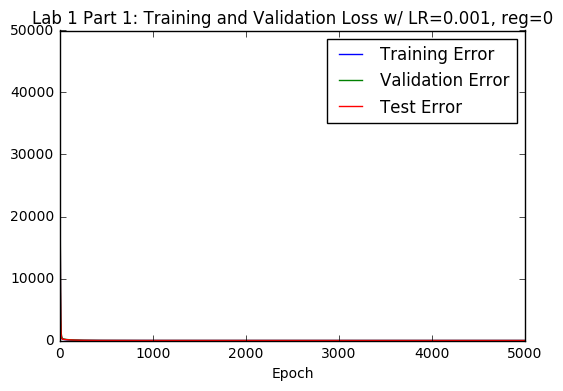

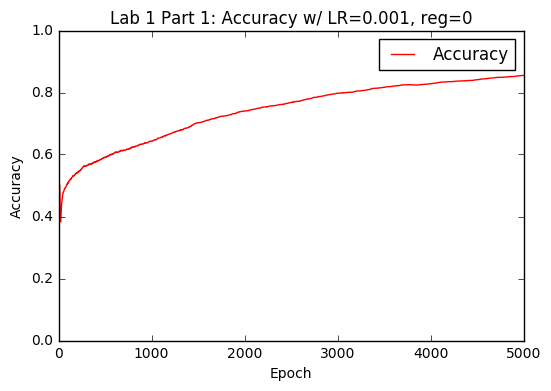

In [46]:
plotLab1(training_loss, validation_loss, test_loss,  accuracy, "0.001", "0")

In [70]:
lr = 0.005
epoch = 5000
reg = 0
W_best,B_best,training_loss,accuracy,validation_loss,test_loss = grad_descent(np.ones(shape=(28,28)), 0, x, y, validData, validTarget, testData, testTarget, 0.005, 300, 0, 10**(-7))

(3500, 28, 28)
(28, 28)
accuracy: 0
Epoch:  0  Error:  4634.578692373464  Accuracy:  0.502
Epoch:  1  Error:  696.9442965107762  Accuracy:  0.4022857142857143
Epoch:  2  Error:  291.24087060253237  Accuracy:  0.3717142857142857
Epoch:  3  Error:  233.96236760836612  Accuracy:  0.4188571428571429
Epoch:  4  Error:  213.37795680894763  Accuracy:  0.43857142857142856
Epoch:  5  Error:  198.39769813080622  Accuracy:  0.4511428571428571
Epoch:  6  Error:  185.52487427313432  Accuracy:  0.4622857142857143
Epoch:  7  Error:  174.0906427091414  Accuracy:  0.4694285714285714
Epoch:  8  Error:  163.7943346598624  Accuracy:  0.4774285714285714
Epoch:  9  Error:  154.4347652456052  Accuracy:  0.4828571428571429
Epoch:  10  Error:  145.8645536089696  Accuracy:  0.48514285714285715
Epoch:  11  Error:  137.97239528253036  Accuracy:  0.49057142857142855
Epoch:  12  Error:  130.67225765924988  Accuracy:  0.4928571428571429
Epoch:  13  Error:  123.89609978675892  Accuracy:  0.4957142857142857
Epoch:  14

In [232]:
def buildGraph(beta1=None, beta2=None, epsilon=None, lossType=None, optimizer = None, learning_rate=0.001, batch_size = 500):
    #Initialize weight and bias tensors
    x, validData, testData, y, validTarget, testTarget = loadData()
    tf.set_random_seed(421)
    W = tf.truncated_normal(shape = (28*28, 1), stddev = 0.5, dtype = tf.float32, seed = 421, name = "weight")
    B = tf.truncated_normal(shape = (1,1), stddev = 0.5, dtype = tf.float32, seed = 421, name = "bias")
    reg = 0
    epoch = 10
    if lossType == "MSE":
        SGD(x, y, validData, validTarget, testData, testTarget, W, B, learning_rate, reg, epoch, batch_size, opt = optimizer, beta1_ = beta1, beta2_ = beta2, epsilon_ = epsilon)
    elif lossType == "CE":
        SGD(x, y, W, B, learning_rate, reg, epoch, batch_size, opt = "Adam", beta1_ = b1, beta2_ = b2, epsilon_ = epsilon)

In [159]:
def data_shuffle(data, label):

    permutation = np.random.permutation(data.shape[0])
    s = np.arange(int(data.shape[0]))
    np.random.shuffle(s)
    shuffled_data = data[s]
    shuffled_label = label[s]

    return shuffled_data, shuffled_label

In [243]:
def SGD(trainData, trainTarget, validData, validTarget, testData, testTarget, W, b, lr, reg, epoch, mini_batch, opt = None, beta1_ = None, beta2_ = None, epsilon_ = None):  
    
    
    #flattening the data
    trainData = np.reshape(trainData, (trainData.shape[0], -1))
    validData = np.reshape(validData, (validData.shape[0], -1))
    testData = np.reshape(testData, (testData.shape[0], -1))
    
    
    #intializing
    SGD_train_losses = []
    SGD_valid_losses = []
    SGD_test_losses = []
    SGD_train_accuracy = []
    SGD_valid_accuracy = []
    SGD_test_accuracy = []
    W = tf.Variable(W)
    b = tf.Variable(b)
    reg = tf.Variable(reg)
    num_of_TrImages = x[0]
    num_of_batches = num_of_TrImages / mini_batch
    
    
    #select fist 500 images that are shuffled
    x_training = trainData[0:(mini_batch-1)]
    y_training = trainTarget[0:(mini_batch -1)]
    y_training_prime = tf.matmul(tf.cast(x_training, tf.float32), W) #might need to add bias here????
    training_loss = tf.losses.mean_squared_error(y_training, predictions = y_training_prime)
    #train_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_training, y_training, 0)) #might have to change bias
    
    
    if opt is None:
        init = tf.global_variables_initializer()
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(training_loss)
    elif opt is "Adam":
        optimizer = tf.train.AdamOptimizer(learning_rate = lr, beta1 = beta1_, beta2 =beta2_, epsilon = epsilon_).minimize(training_loss)
        init = tf.global_variables_initializer()
    
    x_valid = validData[0:99]
    y_valid = validTarget[0:99]
    y_valid_prime = tf.matmul(tf.cast(x_valid, tf.float32), W)
    valid_loss = tf.losses.mean_squared_error(y_valid, predictions = y_valid_prime)
    #valid_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_valid, y_valid, 0)) #might have to change bias
    
    
    x_test = testData[0:144]
    y_test = testTarget[0:144]
    y_test_prime = tf.matmul(tf.cast(x_test, tf.float32), W)
    test_loss = tf.losses.mean_squared_error(y_test, predictions = y_test_prime)
    #test_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_test, y_test, 0)) #might have to change bias
    
    with tf.Session() as sess:
        sess.run(init)
        
        for i in range(epoch):
            sess.run(optimizer)
            
            SGD_train_losses.append(sess.run(training_loss))
            SGD_valid_losses.append(sess.run(valid_loss))
            SGD_test_losses.append(sess.run(test_loss))
            
            train_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_training, y_training, 0))
            valid_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_valid, y_valid, 0)) #might have to change bias
            test_acc = tf.convert_to_tensor(calcAcc(W.eval(), x_test, y_test, 0)) #might have to change bias
            
            SGD_train_accuracy.append(sess.run(train_acc))
            SGD_valid_accuracy.append(sess.run(valid_acc))
            SGD_test_accuracy.append(sess.run(test_acc))
            
            
            
            print("SGD training error:  ",sess.run(training_loss), "SGD val error: ", sess.run(valid_loss), "SGD test error:", sess.run(test_loss))  
            print("SGD training accuracy: ", sess.run(train_acc), "SGD val accuracy: ",  sess.run(valid_acc), "SGD test accuracy: ", sess.run(test_acc))
            
            
            #shuffle the data and target after every epoch    
            trainData, trainTarget = data_shuffle(trainData, trainTarget)
            validData, validTarget = data_shuffle(validData, validTarget)
            testData, testTarget = data_shuffle(testData, testTarget)
            
            
            
        sess.close()
        
        SGD_train_accuracy

        plotLab1(SGD_train_losses, SGD_valid_losses, SGD_test_losses, lr, train_accuracyList = SGD_train_accuracy, valid_accuracyList = SGD_valid_accuracy, test_accuracyList = SGD_test_accuracy)
        
        #return W, b, y_test_prime, y_test, optimizer, reg
        
        


[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

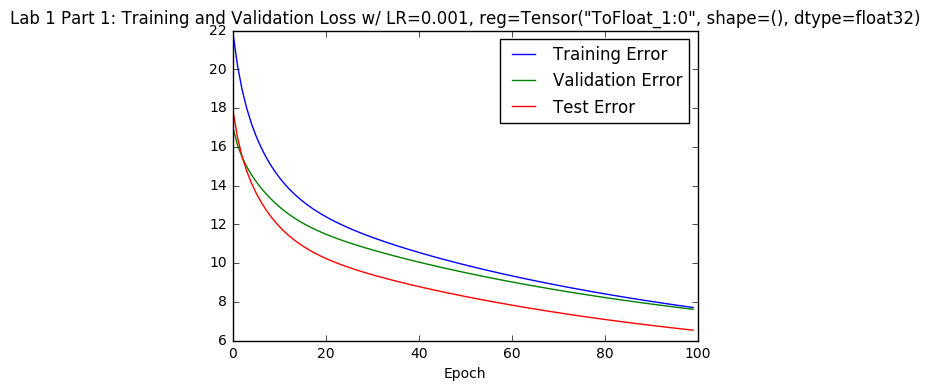

OSError: [Errno 22] Invalid argument: 'lab1_part1_training_loss_plot_lr=0.001_reg=Tensor("ToFloat_1:0", shape=(), dtype=float32).png'

In [178]:
#W = np.ones(shape=(784, 1))
x, validData, testData, y, validTarget, testTarget = loadData()
W = tf.truncated_normal(shape = (28*28, 1), stddev = 0.5, dtype = tf.float32, seed = 421, name = "weight")
SGD(x, y, validData, validTarget, testData, testTarget, W, 0, 0.001, 0, 100, 500)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

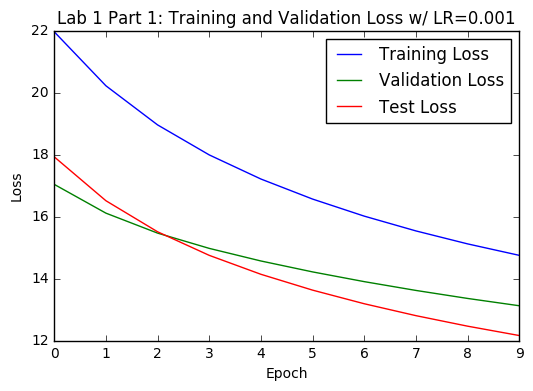

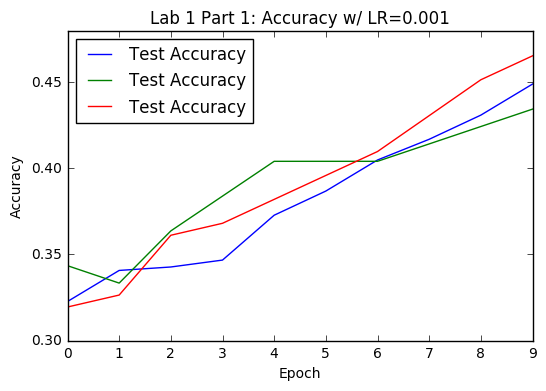

In [219]:
buildGraph(lossType= "MSE")

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

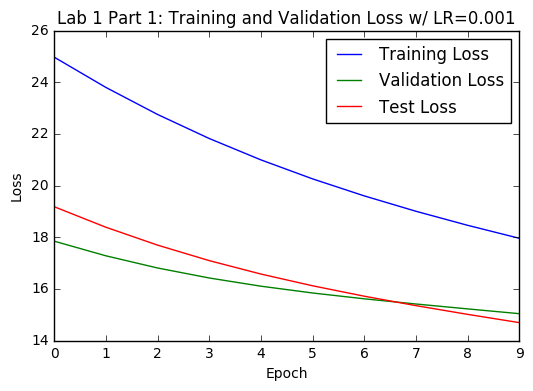

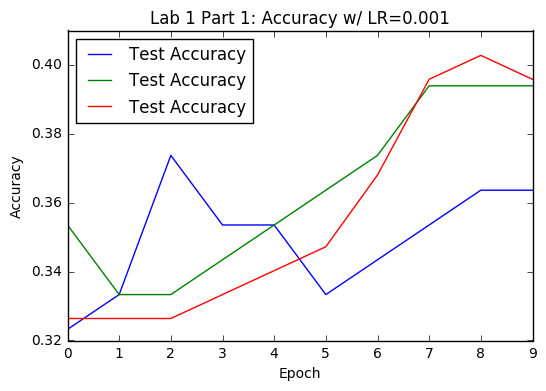

In [246]:
buildGraph(lossType= "MSE", optimizer = "Adam", batch_size = 100, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.00784314 0.00392157 0.        ]
  ...
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.00392157 0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.         0.         0.         ... 0.00392157 0.00392157 0.        ]
  [0.         0.      

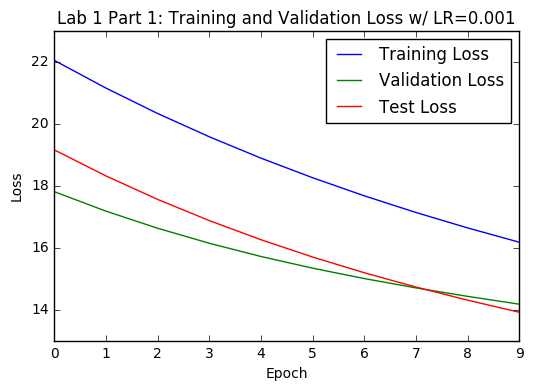

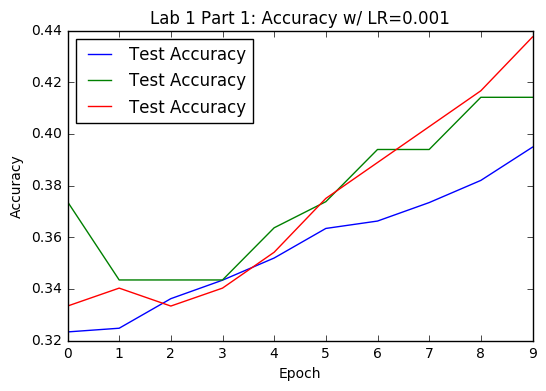

In [247]:
buildGraph(lossType= "MSE", optimizer = "Adam", batch_size = 700, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)